In [57]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [58]:
df_w_vrisis = pd.read_csv('../data/ML.csv')
df_w_vrisis

,Date,Freight_Price,Oil_Price,crisis_COVID-19 oil crash,crisis_Dot-com crash,crisis_Global financial crisis,crisis_Inflation and rate hikes,crisis_Oil price collapse,crisis_None,war_Arab Spring,...,Freight_Lag1,Freight_Lag2,Oil_Lag1,Oil_Lag2,Freight_SMA_3,Oil_SMA_3,has_crisis,has_war,has_sanctions,has_pandemic
0,2002-08-01,728.0,27.47,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,742.0,733.0,25.44,25.58,734.333333,26.163333,1,0,0,0
1,2002-09-01,683.0,28.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,728.0,742.0,27.47,25.44,717.666667,27.220000,1,0,0,0
2,2002-10-01,721.0,25.72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,683.0,728.0,28.75,27.47,710.666667,27.313333,1,0,0,0
3,2002-11-01,886.0,25.16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,721.0,683.0,25.72,28.75,763.333333,26.543333,0,0,0,0
4,2002-12-01,1033.0,28.66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,886.0,721.0,25.16,25.72,880.000000,26.513333,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2024-11-01,663.0,71.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,523.0,554.0,72.81,71.77,580.000000,72.140000,0,1,1,0
268,2024-12-01,625.0,74.24,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,663.0,523.0,71.84,72.81,603.666667,72.963333,0,1,1,0
269,2025-01-01,662.0,75.67,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,625.0,663.0,74.24,71.84,650.000000,73.916667,0,1,1,0
270,2025-02-01,670.0,72.81,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,662.0,625.0,75.67,74.24,652.333333,74.240000,0,1,1,0


In [59]:
df_w_vrisis["Date"] = pd.to_datetime(df_w_vrisis["Date"], format="%Y-%m-%d")
df_w_vrisis.sort_values("Date", inplace=True)
df_w_vrisis.set_index("Date", inplace=True)
df_w_vrisis.index.freq = 'MS'
df_w_vrisis = df_w_vrisis[['Freight_Price', 'Oil_Price', 'has_war', 'has_crisis', 'sin_month', 'cos_month']]
df_w_vrisis = df_w_vrisis.dropna()
df_w_vrisis

,Freight_Price,Oil_Price,has_war,has_crisis,sin_month,cos_month
Date,,,,,,
2002-08-01,728.0,27.47,0,1,-8.660254e-01,-5.000000e-01
2002-09-01,683.0,28.75,0,1,-1.000000e+00,-1.836970e-16
2002-10-01,721.0,25.72,0,1,-8.660254e-01,5.000000e-01
2002-11-01,886.0,25.16,0,0,-5.000000e-01,8.660254e-01
2002-12-01,1033.0,28.66,0,0,-2.449294e-16,1.000000e+00
...,...,...,...,...,...,...
2024-11-01,663.0,71.84,1,0,-5.000000e-01,8.660254e-01
2024-12-01,625.0,74.24,1,0,-2.449294e-16,1.000000e+00
2025-01-01,662.0,75.67,1,0,5.000000e-01,8.660254e-01


In [60]:
X = df_w_vrisis.drop(columns=['Freight_Price'])
y = df_w_vrisis['Freight_Price']

In [61]:
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

In [62]:
param_grid = {
    'num_leaves': [15, 31, 50, 100],
    'max_depth': [4, 10, 20],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
}
lgb_wo_lags = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search_wo_lags = GridSearchCV(estimator=lgb_wo_lags, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_wo_lags.fit(X_train, y_train)
print("Лучшие параметры: ", grid_search_wo_lags.best_params_)
best_model_wo_lags = grid_search_wo_lags.best_estimator_
y_pred_wo_lags = best_model_wo_lags.predict(X_test)
print("MSE без лагов: ", mean_squared_error(y_test, y_pred_wo_lags))
print("MAE без лагов: ", mean_absolute_error(y_test, y_pred_wo_lags))
print("RMSE без лагов: ", root_mean_squared_error(y_test, y_pred_wo_lags))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 5
[LightGBM] [Info] Start training from score 803.929245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

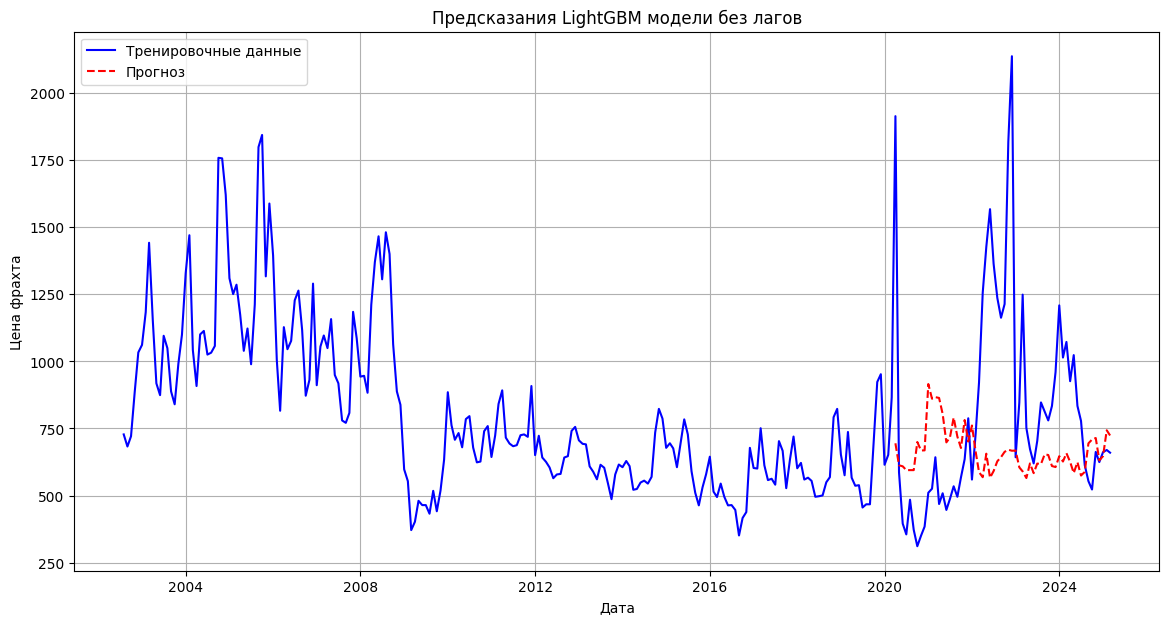

In [63]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(y_test.index, y_pred_wo_lags, label='Прогноз', color='red', linestyle='--')
plt.title('Предсказания LightGBM модели без лагов')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
for lag in [1, 2, 3, 6, 12, 24]:
    df_w_vrisis[f'Freight_Price(t-{lag})'] = df_w_vrisis['Freight_Price'].shift(lag)
    df_w_vrisis[f'Oil_Price(t-{lag})'] = df_w_vrisis['Oil_Price'].shift(lag)
df_w_vrisis = df_w_vrisis.dropna()
X = df_w_vrisis.drop(columns=['Freight_Price'])
y = df_w_vrisis['Freight_Price']
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

In [65]:
lgb_w_lags = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search_w_lags = GridSearchCV(estimator=lgb_w_lags, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_w_lags.fit(X_train, y_train)
print("Лучшие параметры: ", grid_search_w_lags.best_params_)
best_model_w_crisis = grid_search_w_lags.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 17
[LightGBM] [Info] Start training from score 775.563830
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [66]:
# Новый итеративный прогноз с заполнением лагов прогноза новыми значениями

# Тестовый итеративный прогноз на последние 60 месяцев (тестовый период)
forecast_horizon = 60
last_date = X_test.index[0]  # начало тестового периода
# Инициализируем историю лагов из последних 24 значений тренировочного набора
freight_history = list(y_train[-24:])
iterative_predictions = []
current_date = last_date

for i in range(forecast_horizon):
    fp_t1 = freight_history[-1]
    fp_t2 = freight_history[-2] if len(freight_history) >= 2 else freight_history[0]
    fp_t3 = freight_history[-3] if len(freight_history) >= 3 else freight_history[0]
    fp_t6 = freight_history[-6] if len(freight_history) >= 6 else freight_history[0]
    fp_t12 = freight_history[-12] if len(freight_history) >= 12 else freight_history[0]
    fp_t24 = freight_history[-24] if len(freight_history) >= 24 else freight_history[0]
    
    current_date = current_date + pd.DateOffset(months=1)
    month = current_date.month
    sin_month = np.sin(2 * np.pi * month / 12)
    cos_month = np.cos(2 * np.pi * month / 12)
    # Берем неизменными значения остальных признаков из последних строк тренировочного набора
    oil_price = X_train.iloc[-1]['Oil_Price']
    oil_price_t1 = X_train.iloc[-1]['Oil_Price(t-1)']
    oil_price_t2 = X_train.iloc[-1]['Oil_Price(t-2)']
    oil_price_t3 = X_train.iloc[-1]['Oil_Price(t-3)']
    oil_price_t6 = X_train.iloc[-1]['Oil_Price(t-6)']
    oil_price_t12 = X_train.iloc[-1]['Oil_Price(t-12)']
    oil_price_t24 = X_train.iloc[-1]['Oil_Price(t-24)']
    has_war = X_train.iloc[-1]['has_war']
    has_crisis = X_train.iloc[-1]['has_crisis']

    print(f'iter: {i}, fp_t1: {fp_t1}, fp_t2: {fp_t2}')
    
    new_features = {
        'Oil_Price': oil_price,
        'has_war': has_war,
        'has_crisis': has_crisis,
        'sin_month': sin_month,
        'cos_month': cos_month,
        'Freight_Price(t-1)': fp_t1,
        'Freight_Price(t-2)': fp_t2,
        'Freight_Price(t-3)': fp_t3,
        'Freight_Price(t-6)': fp_t6,
        'Freight_Price(t-12)': fp_t12,
        'Freight_Price(t-24)': fp_t24,
        'Oil_Price(t-1)': oil_price_t1,
        'Oil_Price(t-2)': oil_price_t2,
        'Oil_Price(t-3)': oil_price_t3,
        'Oil_Price(t-6)': oil_price_t6,
        'Oil_Price(t-12)': oil_price_t12,
        'Oil_Price(t-24)': oil_price_t24
    }
    new_X = pd.DataFrame([new_features], index=[current_date])
    pred = best_model_w_crisis.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)

forecast_series = pd.Series(iterative_predictions,
    index=pd.date_range(start=X_test.index[1], periods=forecast_horizon, freq='MS'))
print("Тестовый итеративный прогноз для последних 60 месяцев:")
print(forecast_series)

iter: 0, fp_t1: 866.0, fp_t2: 652.0
iter: 1, fp_t1: 741.3193393316863, fp_t2: 866.0
iter: 2, fp_t1: 666.3263576654105, fp_t2: 741.3193393316863
iter: 3, fp_t1: 618.0318289502181, fp_t2: 666.3263576654105
iter: 4, fp_t1: 556.2752108544275, fp_t2: 618.0318289502181
iter: 5, fp_t1: 514.5795401402985, fp_t2: 556.2752108544275
iter: 6, fp_t1: 509.28150369030755, fp_t2: 514.5795401402985
iter: 7, fp_t1: 544.6400487612904, fp_t2: 509.28150369030755
iter: 8, fp_t1: 622.2408035170541, fp_t2: 544.6400487612904
iter: 9, fp_t1: 768.7084404892654, fp_t2: 622.2408035170541
iter: 10, fp_t1: 643.5470140384557, fp_t2: 768.7084404892654
iter: 11, fp_t1: 611.458507491896, fp_t2: 643.5470140384557
iter: 12, fp_t1: 575.8790369070603, fp_t2: 611.458507491896
iter: 13, fp_t1: 581.9528649535797, fp_t2: 575.8790369070603
iter: 14, fp_t1: 569.5820180415639, fp_t2: 581.9528649535797
iter: 15, fp_t1: 572.4510520760361, fp_t2: 569.5820180415639
iter: 16, fp_t1: 564.4019939275995, fp_t2: 572.4510520760361
iter: 17,

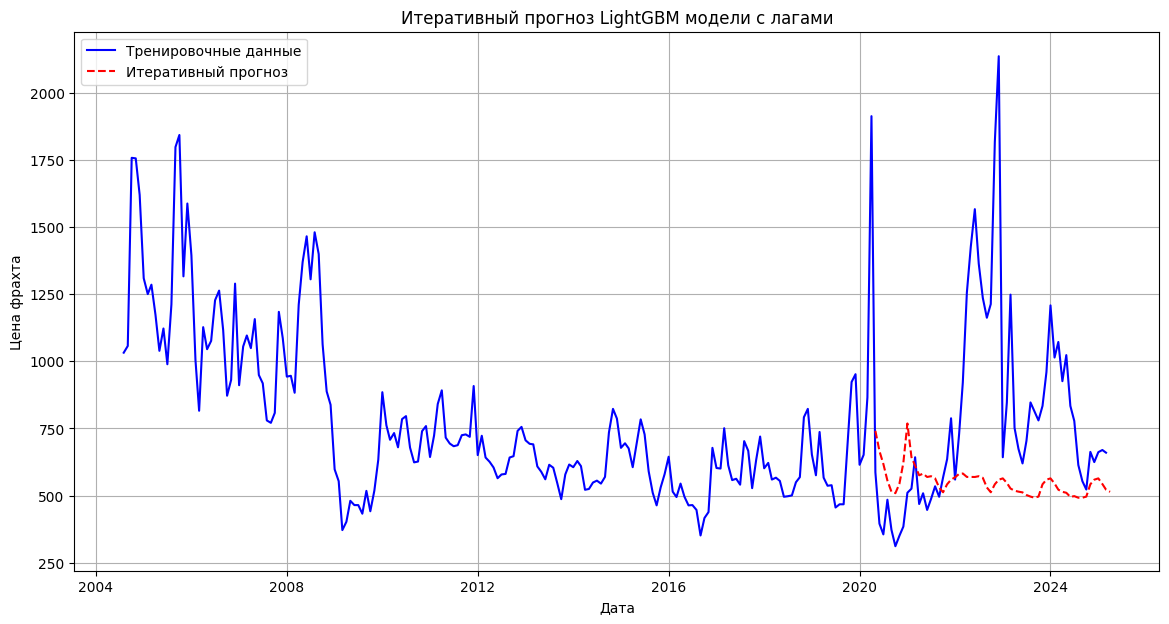

In [67]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Итеративный прогноз', color='red', linestyle='--')
plt.title('Итеративный прогноз LightGBM модели с лагами')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
mse_w_crisis = mean_squared_error(y_test, forecast_series)
mae_w_crisis = mean_absolute_error(y_test, forecast_series)
rmse_w_crisis = root_mean_squared_error(y_test, forecast_series)
print("MSE с лагами: ", mse_w_crisis)
print("MAE с лагами: ", mae_w_crisis)
print("RMSE с лагами: ", rmse_w_crisis)

MSE с лагами:  221506.12747915427
MAE с лагами:  332.17114132920017
RMSE с лагами:  470.6443747450449


In [69]:
from metrics.trend_metrics import TrendMetrics
df_y = pd.DataFrame({'Freight_Price': y_test, 'yhat_exp': forecast_series})
trend_metrics = TrendMetrics(df_y)
print(trend_metrics.summary())

{'Mean Tangent Error': 147.54475427245407, 'Min Tangent Error': 3.6414549290171863, 'Max Tangent Error': 1496.8437335747112, 'Directional Accuracy': 0.6}


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

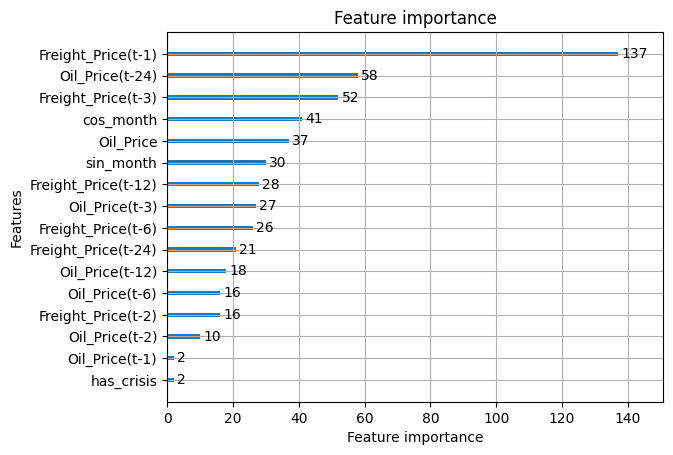

In [70]:
lgb.plot_importance(best_model_w_crisis)

In [71]:
df_w_crisis = pd.read_csv('../data/ML_with_crisis.csv')
df_w_crisis.columns

Index(['Date', 'Freight_Price', 'Oil_Price', 'crisis_COVID-19 oil crash',
       'crisis_Dot-com crash', 'crisis_Global financial crisis',
       'crisis_Inflation and rate hikes', 'crisis_Oil price collapse',
       'crisis_None', 'war_Arab Spring', 'war_Crimea crisis', 'war_Iraq War',
       'war_Ukraine War', 'war_None', 'sanctions_Iran sanctions',
       'sanctions_Russia sanctions', 'sanctions_None', 'pandemic_COVID-19',
       'pandemic_None', 'month', 'year', 'quarter', 'is_year_start',
       'is_year_end', 'sin_month', 'cos_month', 'Freight_Lag1', 'Freight_Lag2',
       'Oil_Lag1', 'Oil_Lag2', 'Freight_SMA_3', 'Oil_SMA_3', 'has_crisis_x',
       'has_war', 'has_sanctions', 'has_pandemic', 'has_crisis_y',
       'crisis_intensity', 'crisis_shock', 'crisis_type_Financial',
       'crisis_type_Pandemic', 'crisis_type_Geopolitical',
       'crisis_type_Natural', 'crisis_type_Logistical'],
      dtype='object')

In [72]:
df_w_vrisis = pd.read_csv('../data/ML_with_crisis.csv')
df_w_vrisis["Date"] = pd.to_datetime(df_w_vrisis["Date"], format="%Y-%m-%d")
df_w_vrisis.sort_values("Date", inplace=True)
df_w_vrisis.set_index("Date", inplace=True)
df_w_vrisis.index.freq = 'MS'
df_w_vrisis = df_w_vrisis.dropna()

# Формирование X, y, train/test
target_col = 'Freight_Price'
X = df_w_vrisis.drop(columns=[target_col])
y = df_w_vrisis[target_col]
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

# Подбор гиперпараметров LightGBM
param_grid = {
    'num_leaves': [15, 31, 50],
    'max_depth': [4, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
}
lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Лучшие параметры:", grid_search.best_params_)
best_model_w_crisis = grid_search.best_estimator_

# Итеративный прогноз
forecast_horizon = 60
last_date = X_test.index[0]
freight_history = list(y_train[-24:])
iterative_predictions = []
current_date = last_date

for i in range(forecast_horizon):
    fp_t1 = freight_history[-1]
    fp_t2 = freight_history[-2] if len(freight_history) >= 2 else freight_history[0]

    # Все признаки из ML_with_crisis
    new_features = {
        'Oil_Price': X_train.iloc[-1]['Oil_Price'],
        'crisis_COVID-19 oil crash': X_train.iloc[-1]['crisis_COVID-19 oil crash'],
        'crisis_Dot-com crash': X_train.iloc[-1]['crisis_Dot-com crash'],
        'crisis_Global financial crisis': X_train.iloc[-1]['crisis_Global financial crisis'],
        'crisis_Inflation and rate hikes': X_train.iloc[-1]['crisis_Inflation and rate hikes'],
        'crisis_Oil price collapse': X_train.iloc[-1]['crisis_Oil price collapse'],
        'crisis_None': X_train.iloc[-1]['crisis_None'],
        'war_Arab Spring': X_train.iloc[-1]['war_Arab Spring'],
        'war_Crimea crisis': X_train.iloc[-1]['war_Crimea crisis'],
        'war_Iraq War': X_train.iloc[-1]['war_Iraq War'],
        'war_Ukraine War': X_train.iloc[-1]['war_Ukraine War'],
        'war_None': X_train.iloc[-1]['war_None'],
        'sanctions_Iran sanctions': X_train.iloc[-1]['sanctions_Iran sanctions'],
        'sanctions_Russia sanctions': X_train.iloc[-1]['sanctions_Russia sanctions'],
        'sanctions_None': X_train.iloc[-1]['sanctions_None'],
        'pandemic_COVID-19': X_train.iloc[-1]['pandemic_COVID-19'],
        'pandemic_None': X_train.iloc[-1]['pandemic_None'],
        'month': current_date.month,
        'year': current_date.year,
        'quarter': X_train.iloc[-1]['quarter'],
        'is_year_start': int(current_date.month == 1),
        'is_year_end': int(current_date.month == 12),
        'sin_month': np.sin(2 * np.pi * current_date.month / 12),
        'cos_month': np.cos(2 * np.pi * current_date.month / 12),
        'Freight_Lag1': fp_t1,
        'Freight_Lag2': fp_t2,
        'Oil_Lag1': X_train.iloc[-1]['Oil_Lag1'],
        'Oil_Lag2': X_train.iloc[-1]['Oil_Lag2'],
        'Freight_SMA_3': X_train.iloc[-1]['Freight_SMA_3'],
        'Oil_SMA_3': X_train.iloc[-1]['Oil_SMA_3'],
        'has_crisis_x': X_train.iloc[-1]['has_crisis_x'],
        'has_war': X_train.iloc[-1]['has_war'],
        'has_sanctions': X_train.iloc[-1]['has_sanctions'],
        'has_pandemic': X_train.iloc[-1]['has_pandemic'],
        'has_crisis_y': X_train.iloc[-1]['has_crisis_y'],
        'crisis_intensity': X_train.iloc[-1]['crisis_intensity'],
        'crisis_shock': X_train.iloc[-1]['crisis_shock'],
        'crisis_type_Financial': X_train.iloc[-1]['crisis_type_Financial'],
        'crisis_type_Pandemic': X_train.iloc[-1]['crisis_type_Pandemic'],
        'crisis_type_Geopolitical': X_train.iloc[-1]['crisis_type_Geopolitical'],
        'crisis_type_Natural': X_train.iloc[-1]['crisis_type_Natural'],
        'crisis_type_Logistical': X_train.iloc[-1]['crisis_type_Logistical'],
    }

    new_X = pd.DataFrame([new_features], index=[current_date])
    pred = best_model_w_crisis.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)

forecast_series2 = pd.Series(iterative_predictions,
    index=pd.date_range(start=X_test.index[1], periods=forecast_horizon, freq='MS'))
print("Тестовый итеративный прогноз для последних 60 месяцев:")
print(forecast_series2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 583
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 26
[LightGBM] [Info] Start training from score 803.929245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

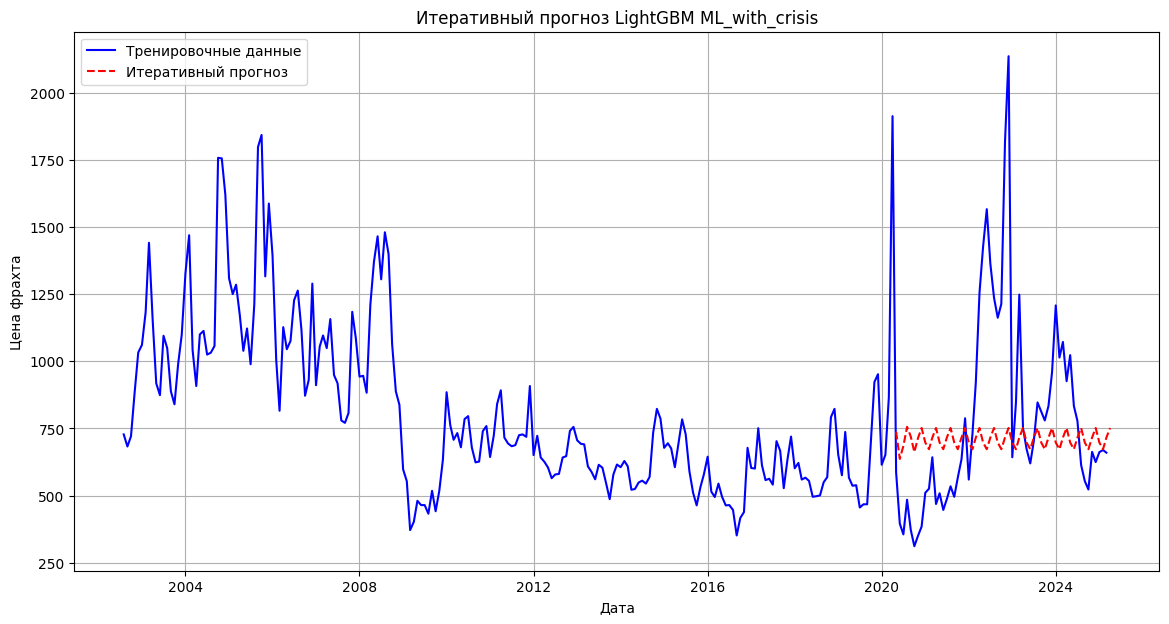

In [73]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(forecast_series2.index, forecast_series2, label='Итеративный прогноз', color='red', linestyle='--')
plt.title('Итеративный прогноз LightGBM ML_with_crisis')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
mse_w_crisis = mean_squared_error(y_test, forecast_series2)
mae_w_crisis = mean_absolute_error(y_test, forecast_series2)
rmse_w_crisis = root_mean_squared_error(y_test, forecast_series2)
print("MSE с лагами: ", mse_w_crisis)
print("MAE с лагами: ", mae_w_crisis)
print("RMSE с лагами: ", rmse_w_crisis)
df_y = pd.DataFrame({'Freight_Price': y_test, 'yhat_exp': forecast_series2})
trend_metrics = TrendMetrics(df_y)
print(trend_metrics.summary())

MSE с лагами:  161981.2333612762
MAE с лагами:  281.05680756862563
RMSE с лагами:  402.4689222303707
{'Mean Tangent Error': 143.32940412899433, 'Min Tangent Error': 2.3391847067363187, 'Max Tangent Error': 1437.9586204390357, 'Directional Accuracy': 0.5833333333333334}


In [75]:
df_w_crisis

,Date,Freight_Price,Oil_Price,crisis_COVID-19 oil crash,crisis_Dot-com crash,crisis_Global financial crisis,crisis_Inflation and rate hikes,crisis_Oil price collapse,crisis_None,war_Arab Spring,...,has_sanctions,has_pandemic,has_crisis_y,crisis_intensity,crisis_shock,crisis_type_Financial,crisis_type_Pandemic,crisis_type_Geopolitical,crisis_type_Natural,crisis_type_Logistical
0,2002-08-01,728.0,27.47,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
1,2002-09-01,683.0,28.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
2,2002-10-01,721.0,25.72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
3,2002-11-01,886.0,25.16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
4,2002-12-01,1033.0,28.66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2024-11-01,663.0,71.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0.0,0,0,0,0,0,0
268,2024-12-01,625.0,74.24,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0.0,0,0,0,0,0,0
269,2025-01-01,662.0,75.67,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0.0,0,0,0,0,0,0
270,2025-02-01,670.0,72.81,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,0,0,0.0,0,0,0,0,0,0


In [76]:
df_w_crisis = df_w_crisis[['Freight_Price', 'Oil_Price', 'crisis_COVID-19 oil crash',
       'crisis_Dot-com crash', 'crisis_Global financial crisis',
       'crisis_Inflation and rate hikes', 'crisis_Oil price collapse', 'war_Arab Spring', 'war_Iraq War',
       'war_Ukraine War', 'sanctions_Iran sanctions',
       'sanctions_Russia sanctions', 'quarter',
       'is_year_end', 'sin_month', 'cos_month',
       'Oil_Lag1', 'Oil_Lag2', 'has_crisis_x',
       'has_war', 'has_sanctions', 'has_pandemic', 'has_crisis_y',
       'crisis_intensity', 'crisis_shock', 'crisis_type_Financial',
       'crisis_type_Pandemic', 'crisis_type_Geopolitical',
       'crisis_type_Natural', 'crisis_type_Logistical']]


In [77]:
df_w_crisis

,Freight_Price,Oil_Price,crisis_COVID-19 oil crash,crisis_Dot-com crash,crisis_Global financial crisis,crisis_Inflation and rate hikes,crisis_Oil price collapse,war_Arab Spring,war_Iraq War,war_Ukraine War,...,has_sanctions,has_pandemic,has_crisis_y,crisis_intensity,crisis_shock,crisis_type_Financial,crisis_type_Pandemic,crisis_type_Geopolitical,crisis_type_Natural,crisis_type_Logistical
0,728.0,27.47,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
1,683.0,28.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
2,721.0,25.72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
3,886.0,25.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
4,1033.0,28.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,663.0,71.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0.0,0,0,0,0,0,0
268,625.0,74.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0.0,0,0,0,0,0,0
269,662.0,75.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0.0,0,0,0,0,0,0
270,670.0,72.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0.0,0,0,0,0,0,0


In [78]:
df_w_crisis['Oil_Lag3'] = df_w_crisis['Oil_Price'].shift(3)
df_w_crisis['Oil_Lag6'] = df_w_crisis['Oil_Price'].shift(6)
df_w_crisis['Oil_Lag12'] = df_w_crisis['Oil_Price'].shift(12)
df_w_crisis = df_w_crisis.dropna()

C:\Users\zvnlxn\AppData\Local\Temp\ipykernel_9184\1543462437.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_crisis['Oil_Lag3'] = df_w_crisis['Oil_Price'].shift(3)
C:\Users\zvnlxn\AppData\Local\Temp\ipykernel_9184\1543462437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_crisis['Oil_Lag6'] = df_w_crisis['Oil_Price'].shift(6)
C:\Users\zvnlxn\AppData\Local\Temp\ipykernel_9184\1543462437.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [79]:
df_w_crisis

,Freight_Price,Oil_Price,crisis_COVID-19 oil crash,crisis_Dot-com crash,crisis_Global financial crisis,crisis_Inflation and rate hikes,crisis_Oil price collapse,war_Arab Spring,war_Iraq War,war_Ukraine War,...,crisis_intensity,crisis_shock,crisis_type_Financial,crisis_type_Pandemic,crisis_type_Geopolitical,crisis_type_Natural,crisis_type_Logistical,Oil_Lag3,Oil_Lag6,Oil_Lag12
12,1049.0,29.49,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,0,0,26.32,32.79,27.47
13,888.0,27.61,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,0,0,28.33,27.18,28.75
14,840.0,27.70,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,0,0,28.37,23.68,25.72
15,991.0,28.45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,0,0,29.49,26.32,25.16
16,1099.0,30.17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,0,0,0,0,0,27.61,28.33,28.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,663.0,71.84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,76.93,81.11,80.86
268,625.0,74.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,71.77,85.00,77.04
269,662.0,75.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,72.81,80.84,81.71
270,670.0,72.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0,0,0,0,0,0,71.84,76.93,81.91


In [85]:
X = df_w_crisis.drop(columns=[target_col])
y = df_w_crisis[target_col]
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]
param_grid = {
    'num_leaves': [2, 5, 10, 31, 50],
    'max_depth': [4, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
}
model_wo_iter = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search_wo_iter = GridSearchCV(estimator=model_wo_iter, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_wo_iter.fit(X_train, y_train)
print("Лучшие параметры:", grid_search_wo_iter.best_params_)
best_model_wo_iter = grid_search_wo_iter.best_estimator_
pred_wo_iter = best_model_wo_iter.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 456
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 20
[LightGBM] [Info] Start training from score 793.285000
Лучшие параметры: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 2, 'subsample': 0.8}


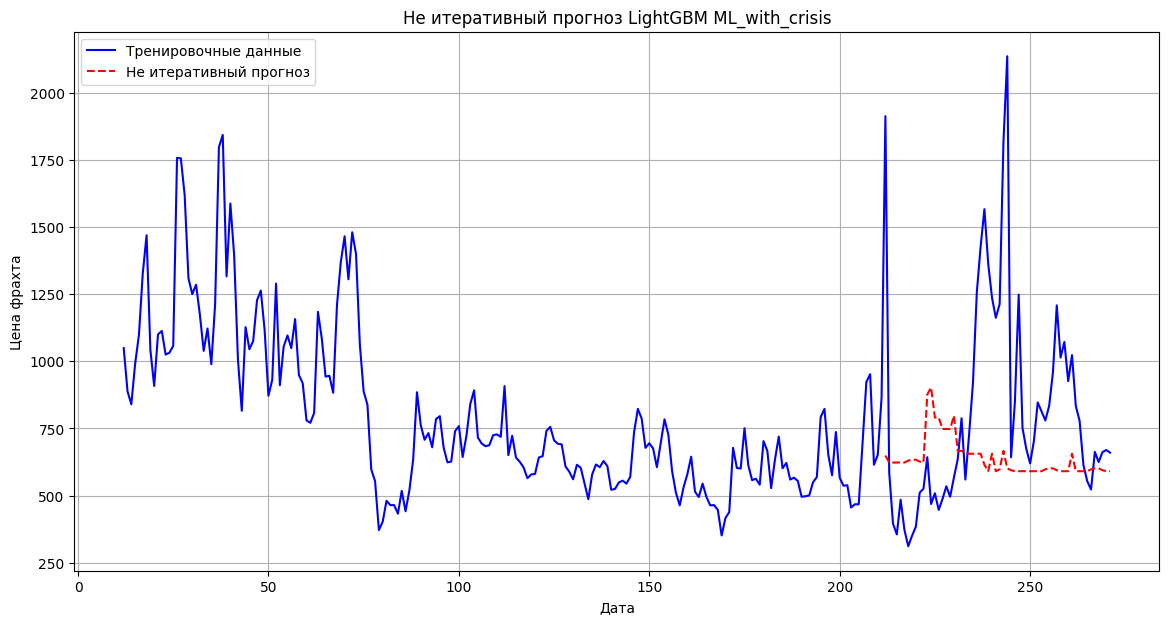

In [86]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(y_test.index, pred_wo_iter, label='Не итеративный прогноз', color='red', linestyle='--')
plt.title('Не итеративный прогноз LightGBM ML_with_crisis')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [88]:
mse_wo_iter = mean_squared_error(y_test, pred_wo_iter)
mae_wo_iter = mean_absolute_error(y_test, pred_wo_iter)
rmse_wo_iter = root_mean_squared_error(y_test, pred_wo_iter)
print("MSE: ", mse_wo_iter)
print("MAE: ", mae_wo_iter)
print("RMSE: ", rmse_wo_iter)
df_y_wo_iter = pd.DataFrame({'Freight_Price': y_test, 'yhat_exp': pred_wo_iter})
trend_metrics_wo_iter = TrendMetrics(df_y_wo_iter)
print(trend_metrics_wo_iter.summary())

MSE:  200521.29161202395
MAE:  321.76697872244455
RMSE:  447.79603795927443
{'Mean Tangent Error': 175.07271667890157, 'Min Tangent Error': 8.93332648312014, 'Max Tangent Error': 1484.9221067248995, 'Directional Accuracy': 0.711864406779661}
